In [1]:
from google.colab import files
files.upload()

!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d nazmul0087/ct-kidney-dataset-normal-cyst-tumor-and-stone --unzip

Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/nazmul0087/ct-kidney-dataset-normal-cyst-tumor-and-stone
License(s): copyright-authors
 99% 1.50G/1.52G [00:07<00:00, 240MB/s]
100% 1.52G/1.52G [00:07<00:00, 206MB/s]


In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, auc, classification_report
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from tqdm import tqdm
import shutil

# Set random seeds
np.random.seed(42)
tf.random.set_seed(42)

# ===== EXPLICIT GPU CONFIGURATION =====
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Set memory growth to prevent OOM errors
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)

        # Use first GPU only
        tf.config.set_visible_devices(gpus[0], 'GPU')
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(f"{len(gpus)} Physical GPU(s), {len(logical_gpus)} Logical GPU(s)")

        # Enable mixed precision for 2-3x speedup
        policy = tf.keras.mixed_precision.Policy('mixed_float16')
        tf.keras.mixed_precision.set_global_policy(policy)
        print(f"Mixed precision enabled: {policy.name}")

    except RuntimeError as e:
        print(e)
else:
    print("No GPU available. Using CPU.")
# =====================================

# Verify GPU
print("\nGPU STATUS:")
print(f"TensorFlow Version: {tf.__version__}")
print(f"GPU Devices: {tf.config.list_physical_devices('GPU')}")
print(f"GPU Device Name: {tf.test.gpu_device_name() or 'None'}")
!nvidia-smi

1 Physical GPU(s), 1 Logical GPU(s)
Mixed precision enabled: mixed_float16

GPU STATUS:
TensorFlow Version: 2.18.0
GPU Devices: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
GPU Device Name: /device:GPU:0
Tue Aug  5 14:49:51 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A 

In [3]:
# Define paths
inputFolder = "/content/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone"
outputFolder = "/content/Output"

# Create directory structure
for split in ['train', 'validation', 'test']:
    for class_name in ['Normal', 'Cyst', 'Tumor', 'Stone']:
        os.makedirs(os.path.join(outputFolder, split, class_name), exist_ok=True)

In [4]:
# Prepare data paths and labels
class_names = sorted(os.listdir(inputFolder))
file_paths = []
labels = []

for class_idx, class_name in enumerate(class_names):
    class_path = os.path.join(inputFolder, class_name)
    for filename in os.listdir(class_path):
        file_paths.append(os.path.join(class_path, filename))
        labels.append(class_idx)

# Stratified train-val-test split
X_train, X_temp, y_train, y_temp = train_test_split(
    file_paths, labels, test_size=0.3, stratify=labels, random_state=42
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42
)

In [5]:
# Function to copy files to respective directories
def copy_files(file_paths, labels, split_name):
    for file_path, label in tqdm(zip(file_paths, labels), total=len(file_paths), desc=f"Copying {split_name} files"):
        class_name = class_names[label]
        filename = os.path.basename(file_path)
        dest_path = os.path.join(outputFolder, split_name, class_name, filename)
        shutil.copy(file_path, dest_path)

# Execute copying
copy_files(X_train, y_train, 'train')
copy_files(X_val, y_val, 'validation')
copy_files(X_test, y_test, 'test')

Copying test files: 100%|██████████| 1867/1867 [00:00<00:00, 1905.06it/s]


In [6]:
# Setup augmentation
target_size = (224, 224)  # ResNet50 input size
aug_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=45,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.7, 1.3],
    fill_mode='reflect'
)

# Generate augmented images
num_augmentations = 5
print("Generating augmented images for training...")
for file_path, label in tqdm(zip(X_train, y_train), total=len(X_train), desc="Augmenting training images"):
    class_name = class_names[label]
    img = tf.keras.preprocessing.image.load_img(file_path, target_size=target_size)
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = img_array.reshape((1,) + img_array.shape)
    i = 0
    for batch in aug_datagen.flow(img_array, batch_size=1,
                                 save_to_dir=os.path.join(outputFolder, 'train', class_name),
                                 save_prefix='aug', save_format='jpeg'):
        i += 1
        if i >= num_augmentations:
            break

Generating augmented images for training...


Augmenting training images: 100%|██████████| 8712/8712 [10:12<00:00, 14.22it/s]


In [7]:
# Print dataset statistics
for split in ['train', 'validation', 'test']:
    print(f"\n{split.capitalize()} Split:")
    total = 0
    for class_name in class_names:
        path = os.path.join(outputFolder, split, class_name)
        num_images = len(os.listdir(path))
        print(f"{class_name}: {num_images} images")
        total += num_images
    print(f"Total {split} images: {total}")

# Calculate class weights
class_counts = np.bincount(labels)
total_samples = sum(class_counts)
class_weights = {i: total_samples / (len(class_counts) * count) for i, count in enumerate(class_counts)}

print("\nClass Weights:")
for i, class_name in enumerate(class_names):
    print(f"{class_name}: {class_weights[i]:.4f}")


Train Split:
Cyst: 9828 images
Normal: 11856 images
Stone: 4763 images
Tumor: 7098 images
Total train images: 33545

Validation Split:
Cyst: 556 images
Normal: 762 images
Stone: 206 images
Tumor: 343 images
Total validation images: 1867

Test Split:
Cyst: 557 images
Normal: 761 images
Stone: 207 images
Tumor: 342 images
Total test images: 1867

Class Weights:
Cyst: 0.8389
Normal: 0.6129
Stone: 2.2596
Tumor: 1.3629


In [8]:
# Create data generators using tf.data API for better performance
def create_dataset(path, batch_size=64, shuffle=False):
    ds = tf.keras.utils.image_dataset_from_directory(
        path,
        labels='inferred',
        label_mode='categorical',
        color_mode='rgb',
        batch_size=batch_size,
        image_size=target_size,
        shuffle=shuffle,
        seed=42
    )

    # Apply ResNet50 preprocessing
    def preprocess(image, label):
        return preprocess_input(image), label

    return ds.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE
                 ).prefetch(tf.data.AUTOTUNE)

# Create datasets
batch_size = 64  # Larger batch size for ResNet

train_ds = create_dataset(
    os.path.join(outputFolder, 'train'),
    batch_size=batch_size,
    shuffle=True
)

val_ds = create_dataset(
    os.path.join(outputFolder, 'validation'),
    batch_size=batch_size
)

test_ds = create_dataset(
    os.path.join(outputFolder, 'test'),
    batch_size=batch_size
)

# Print dataset info
print(f"\nTraining samples: {train_ds.cardinality().numpy() * batch_size}")
print(f"Validation samples: {val_ds.cardinality().numpy() * batch_size}")
print(f"Test samples: {test_ds.cardinality().numpy() * batch_size}")

# Update references for training
train_generator = train_ds
val_generator = val_ds
test_generator = test_ds

Found 33545 files belonging to 4 classes.
Found 1867 files belonging to 4 classes.
Found 1867 files belonging to 4 classes.

Training samples: 33600
Validation samples: 1920
Test samples: 1920


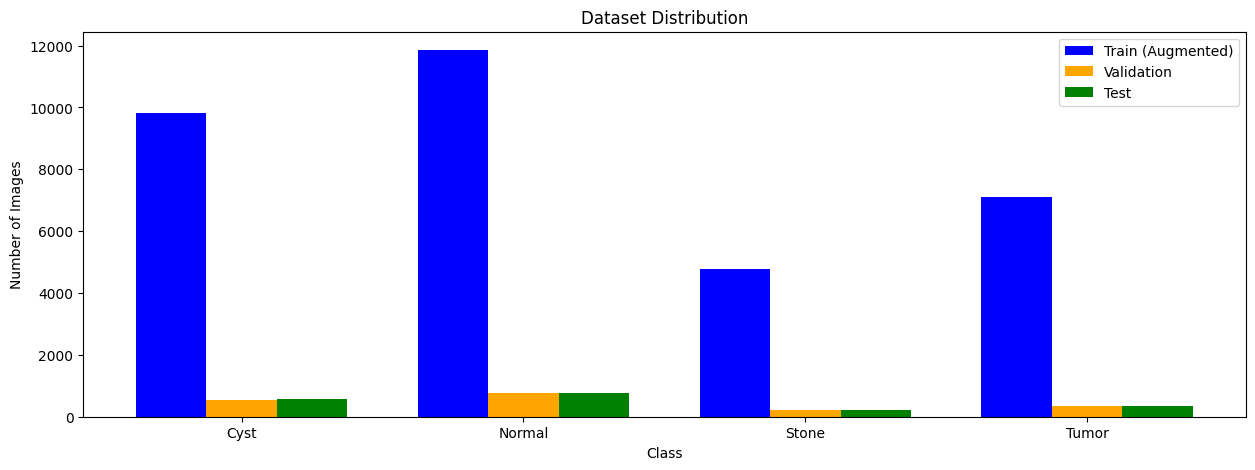

In [9]:
# Visualize data distribution
plt.figure(figsize=(15, 5))
train_counts = [len(os.listdir(os.path.join(outputFolder, 'train', class_name))) for class_name in class_names]
val_counts = [len(os.listdir(os.path.join(outputFolder, 'validation', class_name))) for class_name in class_names]
test_counts = [len(os.listdir(os.path.join(outputFolder, 'test', class_name))) for class_name in class_names]

x = np.arange(len(class_names))
width = 0.25

plt.bar(x - width, train_counts, width, label='Train (Augmented)', color='blue')
plt.bar(x, val_counts, width, label='Validation', color='orange')
plt.bar(x + width, test_counts, width, label='Test', color='green')

plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.title('Dataset Distribution')
plt.xticks(x, class_names)
plt.legend()
plt.show()

In [10]:
# Build ResNet50 model with partial unfreezing
def create_resnet_model():
    # Load pre-trained ResNet50 base
    base_model = ResNet50(
        weights='imagenet',
        include_top=False,
        input_shape=(224, 224, 3)
    )

    # Unfreeze top 100 layers while freezing bottom layers
    base_model.trainable = True
    for layer in base_model.layers[:100]:
        layer.trainable = False

    # Print freezing statistics
    total_layers = len(base_model.layers)
    trainable_layers = sum([layer.trainable for layer in base_model.layers])
    print(f"Unfrozen layers: {trainable_layers}/{total_layers} (≈{trainable_layers/total_layers:.1%})")

    # Build custom head
    inputs = tf.keras.Input(shape=(224, 224, 3))
    x = base_model(inputs, training=True)  # Important for BN layers
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    outputs = Dense(4, activation='softmax', dtype='float32')(x)  # Output in float32

    model = Model(inputs, outputs)

    # Compile with adjusted LR
    model.compile(
        optimizer=Adam(learning_rate=0.0003),
        loss='categorical_crossentropy',
        metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
    )
    return model

# Create model on GPU
with tf.device('/GPU:0'):
    model = create_resnet_model()

# Detailed summary
print("\nModel Summary:")
model.summary()

# Parameter report
trainable_params = sum([tf.keras.backend.count_params(w) for w in model.trainable_weights])
non_trainable_params = sum([tf.keras.backend.count_params(w) for w in model.non_trainable_weights])
print(f"\nTrainable params: {trainable_params:,}")
print(f"Non-trainable params: {non_trainable_params:,}")
print(f"Total params: {trainable_params + non_trainable_params:,}")

# Verify layer counts
frozen_count = sum(not layer.trainable for layer in model.layers[1].layers)
trainable_count = sum(layer.trainable for layer in model.layers[1].layers)

print(f"\nLayer Report:")
print(f"Total base layers: {len(model.layers[1].layers)}")
print(f"Frozen base layers: {frozen_count}")
print(f"Trainable base layers: {trainable_count}")
print(f"Custom head layers: 4 (all trainable)")

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Unfrozen layers: 75/175 (≈42.9%)

Model Summary:


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │     2,098,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cast_1 (Cast)                   │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         4,100 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,694,084 (98.02 MB)

 Trainable params: 21,557,252 (82.23 MB)

 Non-trainable params: 4,136,832 (15.78 MB)


Trainable params: 21,557,252
Non-trainable params: 4,136,832
Total params: 25,694,084

Layer Report:
Total base layers: 175
Frozen base layers: 100
Trainable base layers: 75
Custom head layers: 4 (all trainable)


In [11]:
# Define callbacks
callbacks = [
    EarlyStopping(
        patience=15,  # More patience for 50 epochs
        monitor='val_loss',
        restore_best_weights=True,
        verbose=1
    ),
    ModelCheckpoint(
        'best_resnet_model.keras',
        save_best_only=True,
        monitor='val_loss',
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,  # More patience before reducing LR
        min_lr=1e-6,
        verbose=1
    ),
    tf.keras.callbacks.TerminateOnNaN()  # Safety for mixed precision
]

# Start training for 50 epochs
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    validation_data=val_generator,
    validation_steps=len(val_generator),
    epochs=50,  # 50 epochs as requested
    class_weight=class_weights,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/50
525/525 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step - accuracy: 0.8189 - auc: 0.9482 - loss: 0.5817
Epoch 1: val_loss improved from inf to 0.02452, saving model to best_resnet_model.keras
525/525 ━━━━━━━━━━━━━━━━━━━━ 188s 264ms/step - accuracy: 0.8191 - auc: 0.9483 - loss: 0.5811 - val_accuracy: 0.9904 - val_auc: 0.9995 - val_loss: 0.0245 - learning_rate: 3.0000e-04
Epoch 2/50
524/525 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step - accuracy: 0.9750 - auc: 0.9981 - loss: 0.0728
Epoch 2: val_loss improved from 0.02452 to 0.00687, saving model to best_resnet_model.keras
525/525 ━━━━━━━━━━━━━━━━━━━━ 106s 200ms/step - accuracy: 0.9750 - auc: 0.9981 - loss: 0.0728 - val_accuracy: 0.9979 - val_auc: 1.0000 - val_loss: 0.0069 - learning_rate: 3.0000e-04
Epoch 3/50
524/525 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - accuracy: 0.9904 - auc: 0.9995 - loss: 0.0288
Epoch 3: val_loss did not improve from 0.00687
525/525 ━━━━━━━━━━━━━━━━━━━━ 97s 185ms/step - accuracy: 0.9904 - auc: 0.9995 - loss: 0.0288 - val_accurac

30/30 ━━━━━━━━━━━━━━━━━━━━ 16s 356ms/step


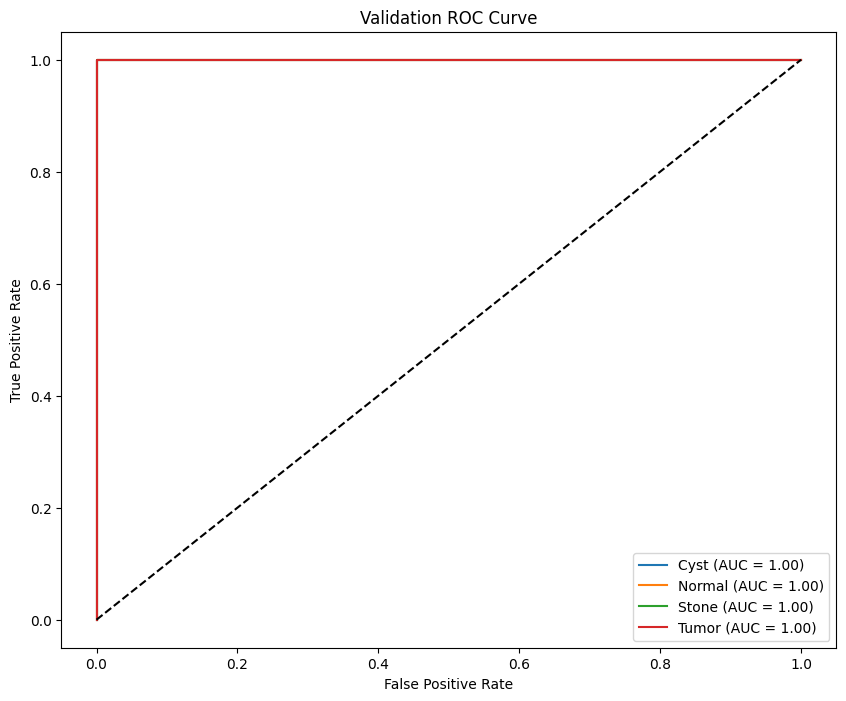

In [13]:
# Load best model
best_model = tf.keras.models.load_model('best_resnet_model.keras')

# Extract true labels from validation dataset
y_true = np.concatenate([labels for _, labels in val_generator], axis=0)
y_true_classes = np.argmax(y_true, axis=1)  # Convert one-hot to class indices

# Validation predictions
y_pred = best_model.predict(val_generator, verbose=1)
y_pred_classes = np.argmax(y_pred, axis=1)

# ROC Curve for validation
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(len(class_names)):
    # Create binary labels for current class
    binary_labels = (y_true_classes == i).astype(int)
    fpr[i], tpr[i], _ = roc_curve(binary_labels, y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10, 8))
for i, name in enumerate(class_names):
    plt.plot(fpr[i], tpr[i], label=f'{name} (AUC = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Validation ROC Curve')
plt.legend()
plt.show()

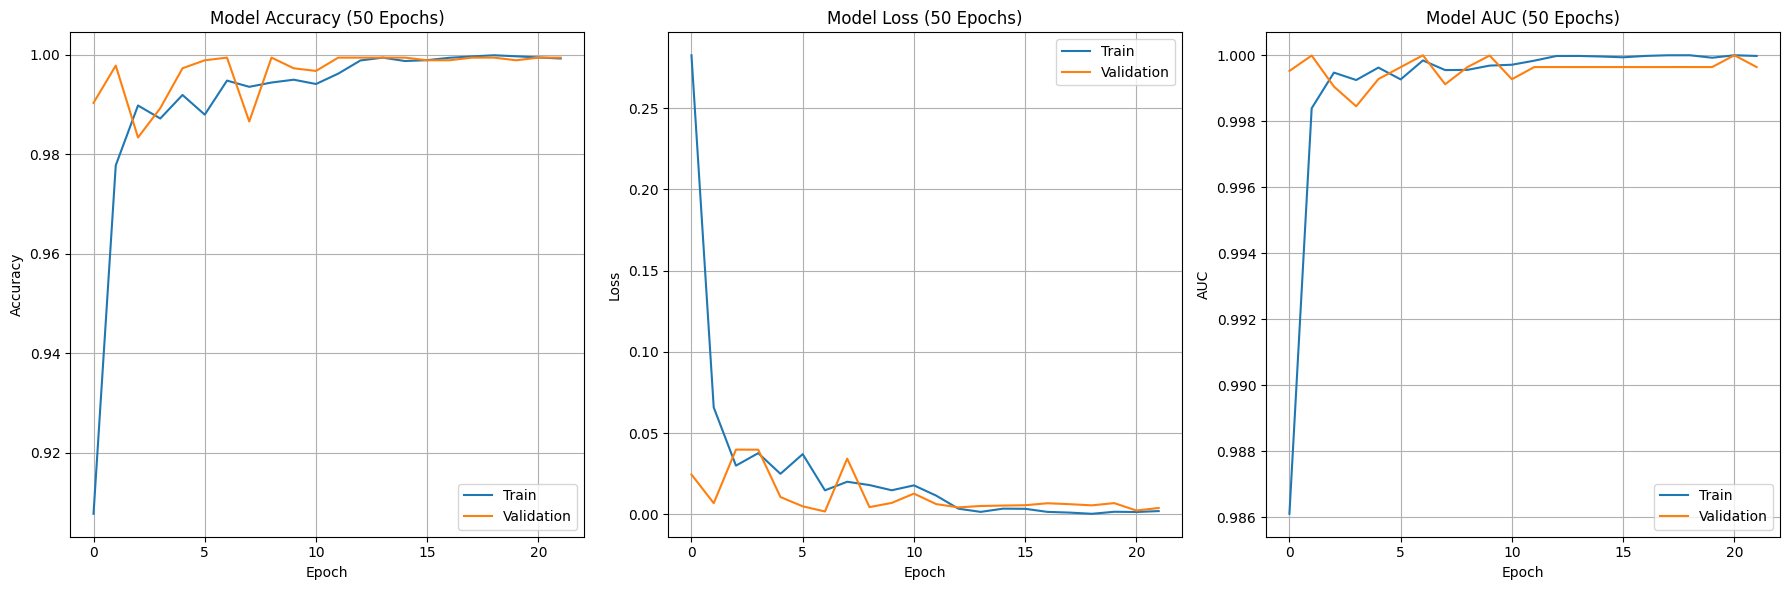

In [14]:
# Plot training history
plt.figure(figsize=(18, 6))

# Accuracy
plt.subplot(1, 3, 1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Model Accuracy (50 Epochs)')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True)

# Loss
plt.subplot(1, 3, 2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model Loss (50 Epochs)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True)

# AUC
plt.subplot(1, 3, 3)
plt.plot(history.history['auc'], label='Train')
plt.plot(history.history['val_auc'], label='Validation')
plt.title('Model AUC (50 Epochs)')
plt.ylabel('AUC')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

30/30 ━━━━━━━━━━━━━━━━━━━━ 8s 263ms/step - accuracy: 0.9997 - auc: 1.0000 - loss: 0.0010    

Test Evaluation:
Loss: 0.0023
Accuracy: 0.9989
AUC: 1.0000


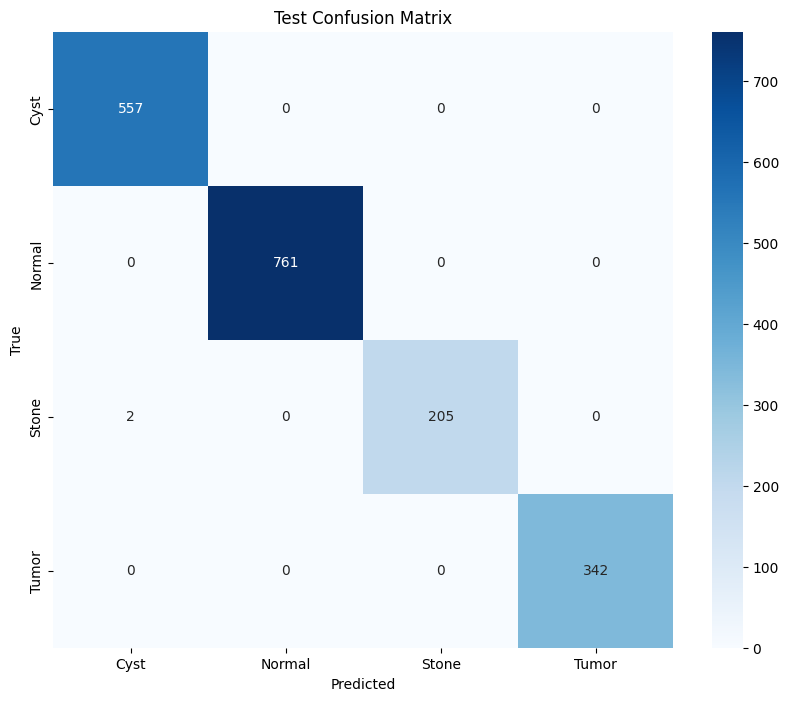


Classification Report:
              precision    recall  f1-score   support

        Cyst       1.00      1.00      1.00       557
      Normal       1.00      1.00      1.00       761
       Stone       1.00      0.99      1.00       207
       Tumor       1.00      1.00      1.00       342

    accuracy                           1.00      1867
   macro avg       1.00      1.00      1.00      1867
weighted avg       1.00      1.00      1.00      1867



In [16]:
# Evaluate on test set
test_loss, test_accuracy, test_auc = best_model.evaluate(test_generator, verbose=1)
print(f"\nTest Evaluation:")
print(f"Loss: {test_loss:.4f}")
print(f"Accuracy: {test_accuracy:.4f}")
print(f"AUC: {test_auc:.4f}")

# Extract true labels and predictions
y_test_true = []
y_test_pred = []

# Iterate through the test dataset to collect all labels and predictions
for images, labels in test_generator:
    y_test_true.extend(labels.numpy())
    preds = best_model.predict(images, verbose=0)
    y_test_pred.extend(preds)

# Convert to numpy arrays
y_test_true = np.array(y_test_true)
y_test_pred = np.array(y_test_pred)
y_test_pred_classes = np.argmax(y_test_pred, axis=1)
y_test_true_classes = np.argmax(y_test_true, axis=1)  # Convert one-hot to class indices

# Confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(
    confusion_matrix(y_test_true_classes, y_test_pred_classes),
    annot=True, fmt='d', cmap='Blues',
    xticklabels=class_names,
    yticklabels=class_names
)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Test Confusion Matrix')
plt.show()

# Classification report
print("\nClassification Report:")
print(classification_report(y_test_true_classes, y_test_pred_classes, target_names=class_names))

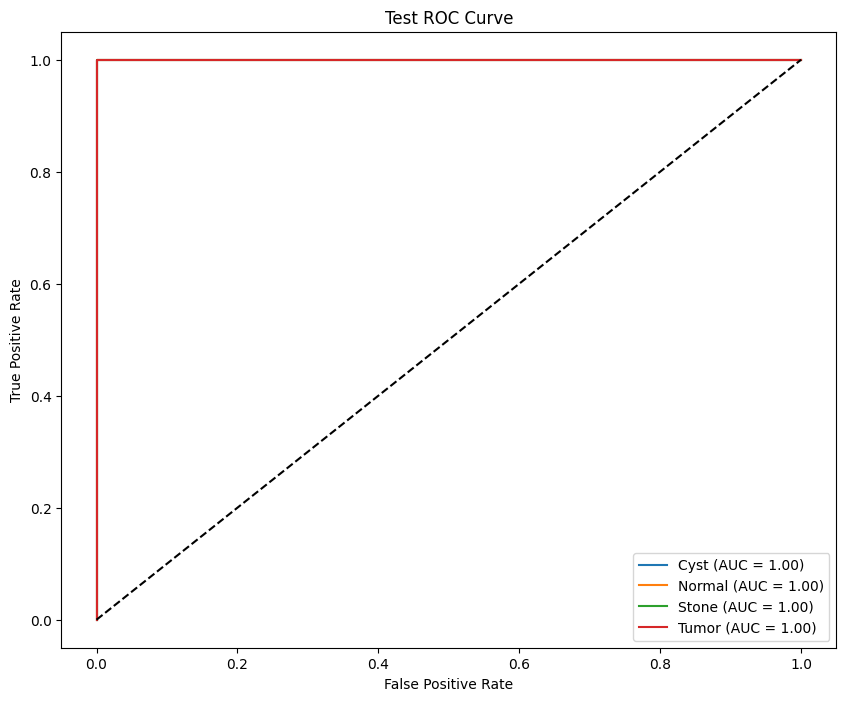

In [18]:
# ROC Curve for test set
fpr_test = dict()
tpr_test = dict()
roc_auc_test = dict()

# Convert one-hot encoded true labels to class indices
y_test_true_classes = np.argmax(y_test_true, axis=1)

for i in range(len(class_names)):
    # Create binary labels for current class (1 for class i, 0 for others)
    binary_labels = (y_test_true_classes == i).astype(int)

    fpr_test[i], tpr_test[i], _ = roc_curve(binary_labels, y_test_pred[:, i])
    roc_auc_test[i] = auc(fpr_test[i], tpr_test[i])

plt.figure(figsize=(10, 8))
for i, name in enumerate(class_names):
    plt.plot(fpr_test[i], tpr_test[i], label=f'{name} (AUC = {roc_auc_test[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Test ROC Curve')
plt.legend()
plt.show()

Sample Predictions:


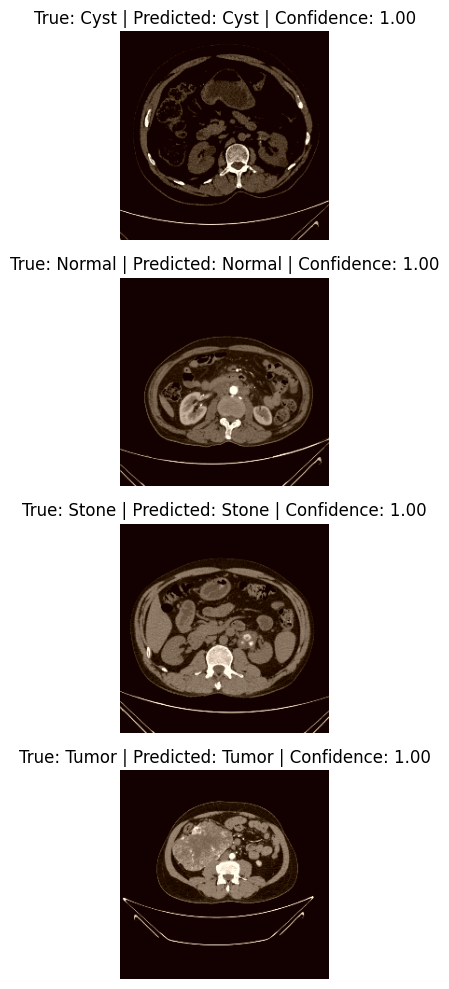

In [20]:
def predict_per_class_samples(model, dataset, class_names):
    # Create a new iterator for the dataset
    iterator = iter(dataset.unbatch().shuffle(1000))

    images = []
    true_labels = []
    found_classes = set()

    # Get one sample per class
    while len(found_classes) < len(class_names):
        try:
            img, lbl = next(iterator)
        except StopIteration:
            # Reset iterator if we reach the end
            iterator = iter(dataset.unbatch().shuffle(1000))
            img, lbl = next(iterator)

        lbl_np = lbl.numpy()
        cls_idx = np.argmax(lbl_np)

        if cls_idx not in found_classes:
            images.append(img.numpy())
            true_labels.append(lbl_np)
            found_classes.add(cls_idx)

    # Plot predictions
    plt.figure(figsize=(15, 10))
    for i, (img, lbl) in enumerate(zip(images, true_labels)):
        # For ResNet preprocessing: reverse the normalization
        img_display = img + [123.68, 116.779, 103.939]  # Add back ImageNet mean
        img_display = np.clip(img_display / 255.0, 0, 1)  # Scale to [0,1]

        true_label = class_names[np.argmax(lbl)]
        pred = model.predict(np.expand_dims(img, axis=0), verbose=0)
        pred_label = class_names[np.argmax(pred)]
        confidence = np.max(pred)

        plt.subplot(len(class_names), 1, i+1)
        plt.imshow(img_display)
        plt.title(f'True: {true_label} | Predicted: {pred_label} | Confidence: {confidence:.2f}')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

print("Sample Predictions:")
predict_per_class_samples(best_model, test_generator, class_names)